In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
cd drive/MyDrive/CS550/SRCNN/

[Errno 2] No such file or directory: 'drive/MyDrive/CS550/SRCNN/'
/content/drive/.shortcut-targets-by-id/1oE8U0pU-coSldw8OMDE7dzHH0664tLkj/CS550/SRCNN


In [4]:
import os
import sys
import shutil
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import transforms
from torchvision import datasets

from helper.distort_images import distort_image
from helper.utils import ycbcr2rgb
from helper.utils import psnr
from helper.evaluate_models import evaluate_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

evaluate_model.DEVICE = device
SR_FACTOR = 3
SIGMA = 1.0

In [5]:
evaluate_model.DEVICE

device(type='cuda')

In [6]:
# generate target training image patches from raw images using train and test of BSDS500

training_img_names = [i for i in os.listdir('./data/train/BSDS500/data/images/train/') if i[-4:] == '.jpg']
training_images_gt_patches = []
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('./data/train/BSDS500/data/images/train/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_train_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_train_Y.shape[0]-32, 13):
            sub_im = im_train_Y[j:j+32, i:i+32]
            training_images_gt_patches.append(sub_im)

# training_img_names = [i for i in os.listdir('./data/train/BSDS500/data/images/test/') if i[-4:] == '.jpg']
# for idx, img_name in enumerate(training_img_names):
#     ImageFile = Image.open('./data/train/BSDS500/data/images/test/'+img_name)
#     im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
#     im_train_Y = im_train[:, :, 0]
#     #crop image to be multiple of 8 in both dims
#     max_x = int(im_train_Y.shape[0]/8) * 8
#     max_y = int(im_train_Y.shape[1]/8) * 8
#     square_dim = min(max_x, max_y)
#     im_train_Y = im_train_Y[0:square_dim, 0:square_dim]
#     # need to extract to patches so that all images are the same size
#     for i in range(0, im_train_Y.shape[1]-32, 13): #every patch vertically with stride 13
#         for j in range(0, im_train_Y.shape[0]-32, 13):
#             sub_im = im_train_Y[j:j+32, i:i+32]
#             training_images_gt_patches.append(sub_im)

In [7]:
# prep target training images to be part of dataset

training_images_gt_patches = np.array(training_images_gt_patches)
print(training_images_gt_patches.shape)

#normalize
training_images_gt_patches /= 255.0

train_pixel_mean = np.mean(training_images_gt_patches)
print(train_pixel_mean)
train_pixel_std = np.std(training_images_gt_patches)
print(train_pixel_std)
#standardize
training_images_gt_patches -= train_pixel_mean
training_images_gt_patches /= train_pixel_std

training_images_gt_patches = torch.tensor(training_images_gt_patches)

(105800, 32, 32)
0.4389407099619167
0.22930474109993115


In [8]:
# generate distorted images for training, using train and test of BSDS500
training_img_names = [i for i in os.listdir('./data/train/BSDS500/data/images/train/') if i[-4:] == '.jpg']
training_images_training_patches = []
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('./data/train/BSDS500/data/images/train/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='./data/train/BSDS500/data/images/train/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            training_images_training_patches.append(sub_im)

# training_img_names = [i for i in os.listdir('./data/train/BSDS500/data/images/test/') if i[-4:] == '.jpg']
# for idx, img_name in enumerate(training_img_names):
#     ImageFile = Image.open('./data/train/BSDS500/data/images/test/'+img_name)
#     im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
#     im_train_Y = im_train[:,:,0]
#     #crop image to be multiple of 8 in both dims
#     max_x = int(im_train_Y.shape[0]/8) * 8
#     max_y = int(im_train_Y.shape[1]/8) * 8
#     square_dim = min(max_x, max_y)
#     im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
#     im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
#     im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]

#     # distort image with blur, downsize and upsize bicubic interpolation
#     im_Y_blur = distort_image(path='./data/train/BSDS500/data/images/test/'+img_name, 
#                               factor=SR_FACTOR, 
#                               sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
#     for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
#         for j in range(0, im_Y_blur.shape[0]-32, 13):
#             sub_im = im_Y_blur[j:j+32, i:i+32]
#             training_images_training_patches.append(sub_im)


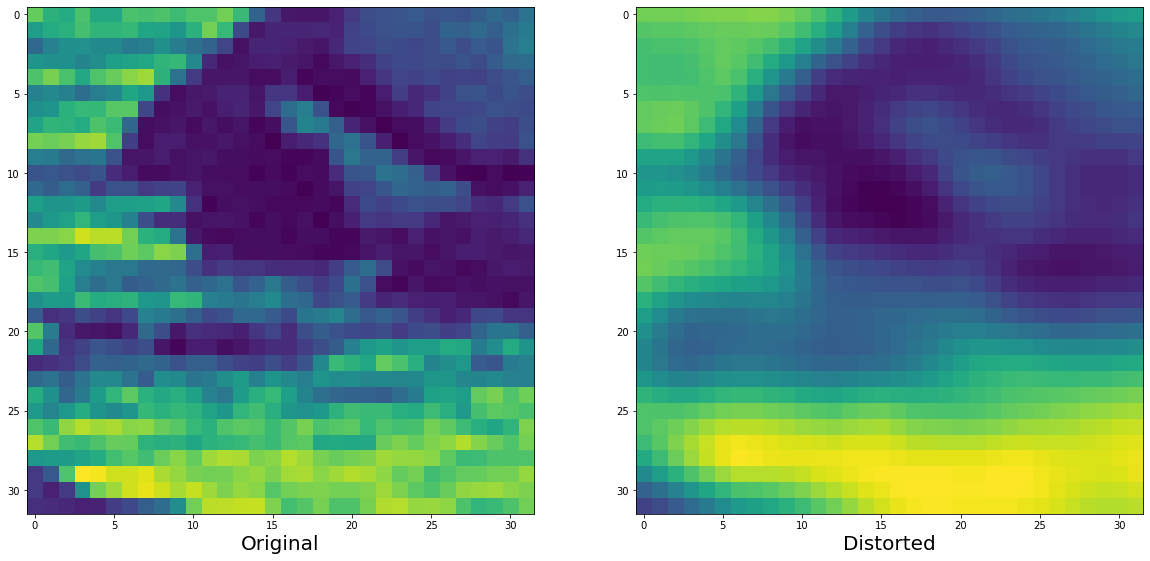

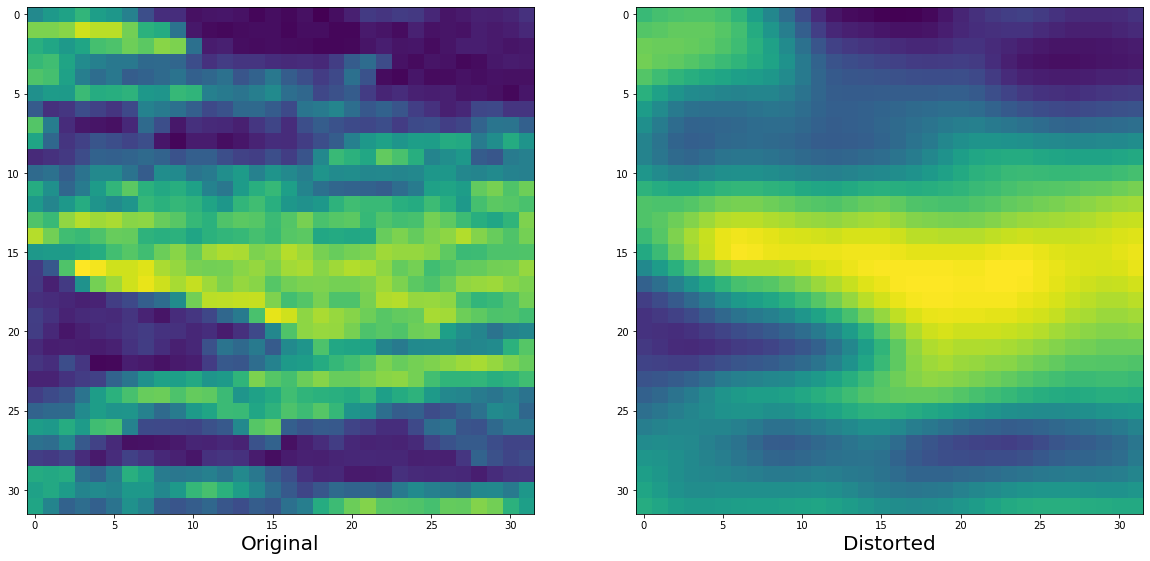

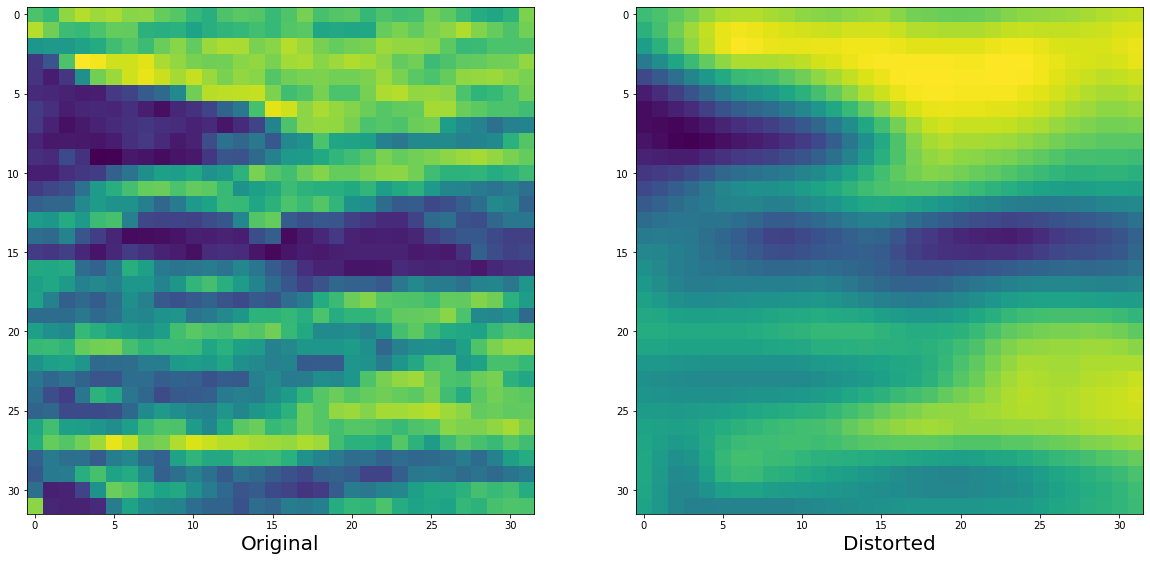

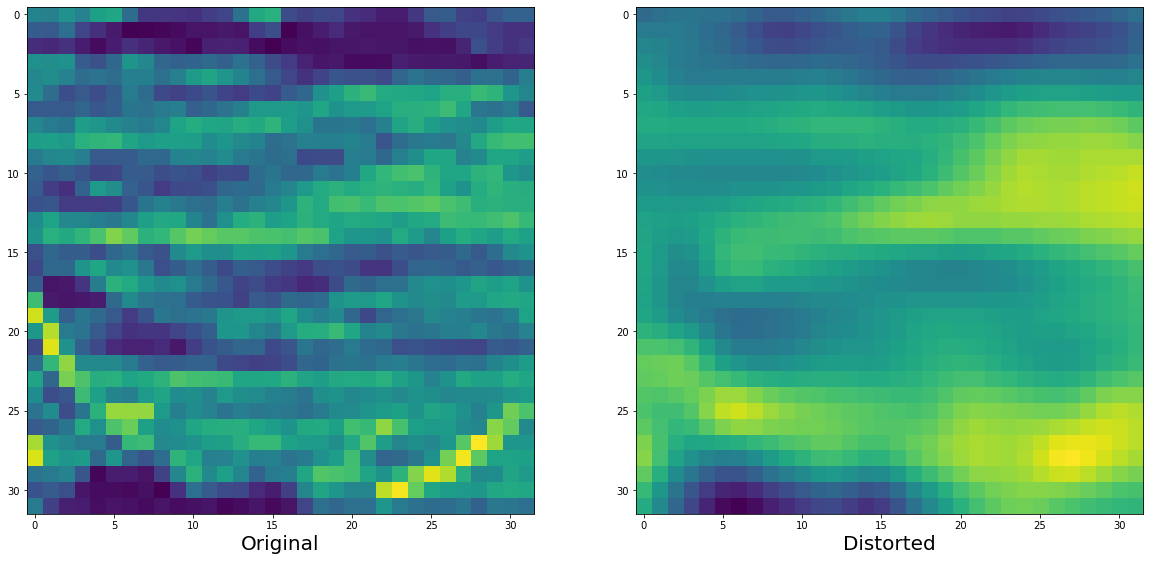

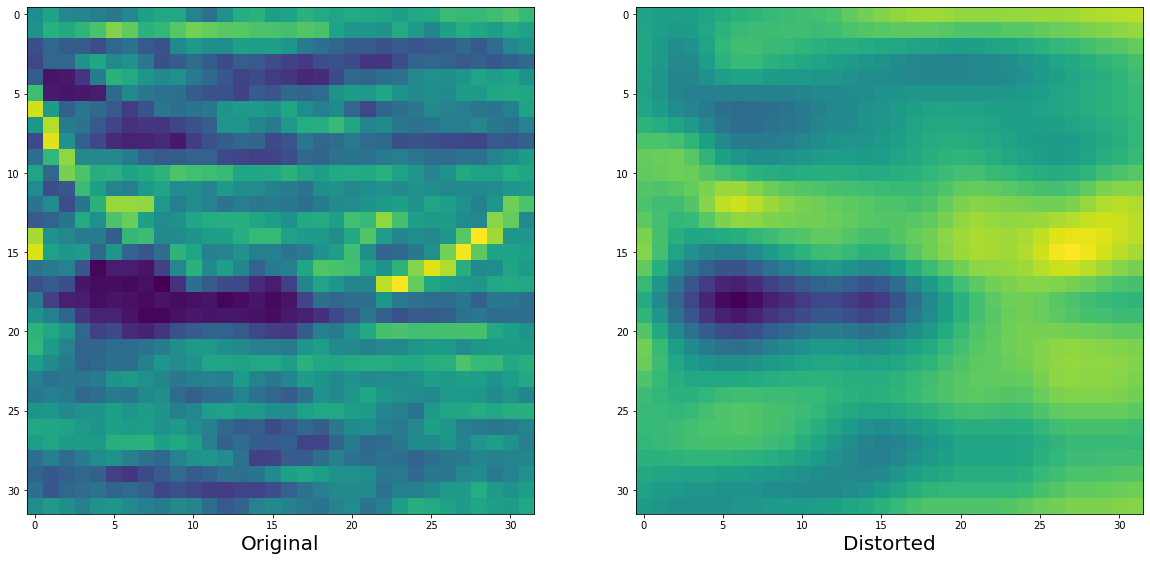

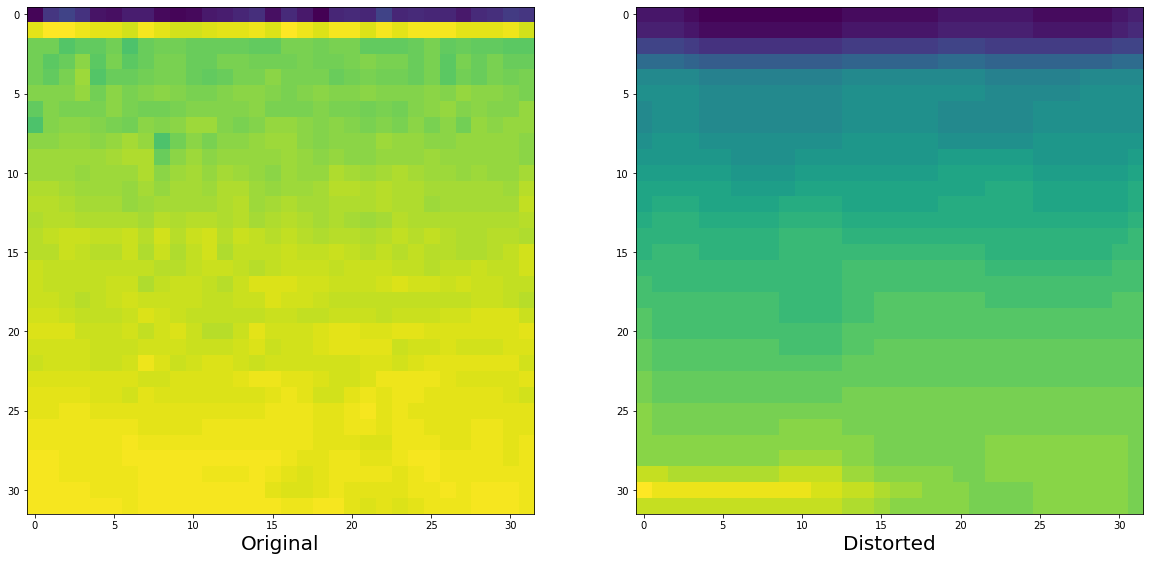

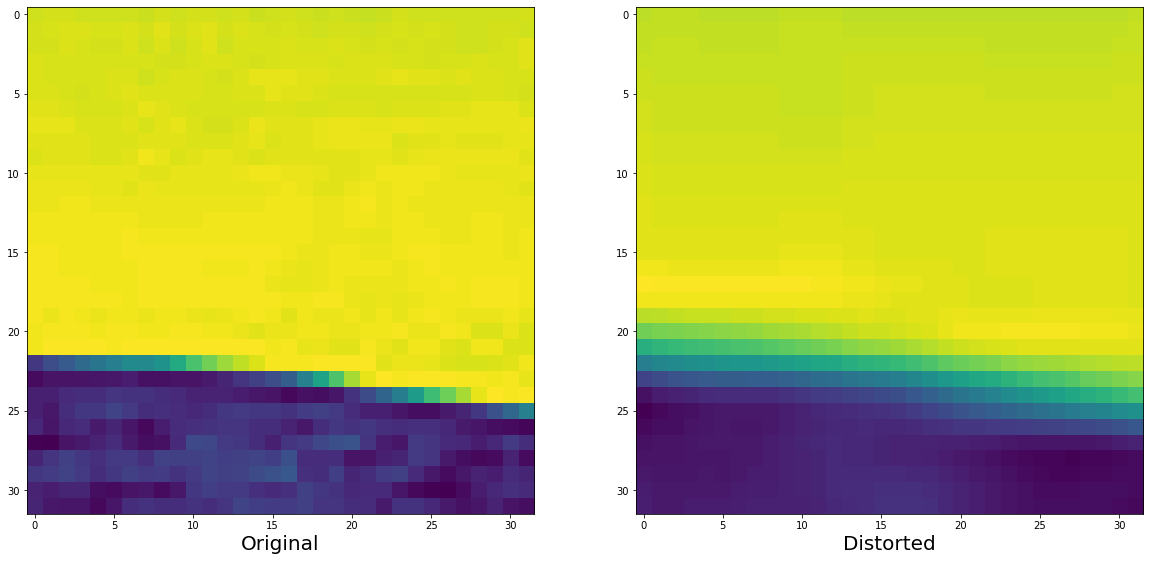

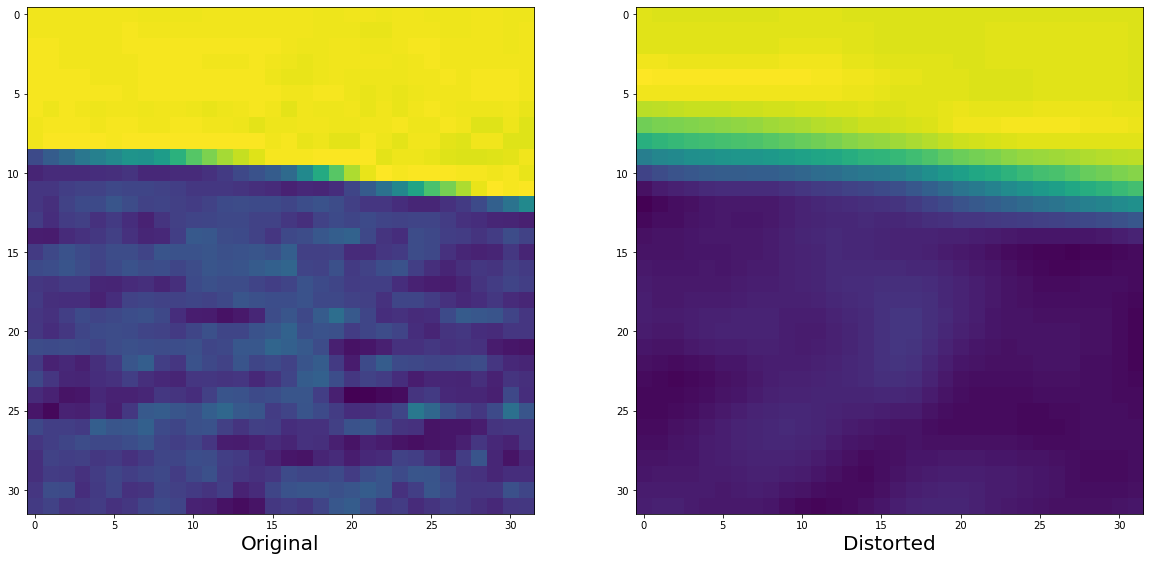

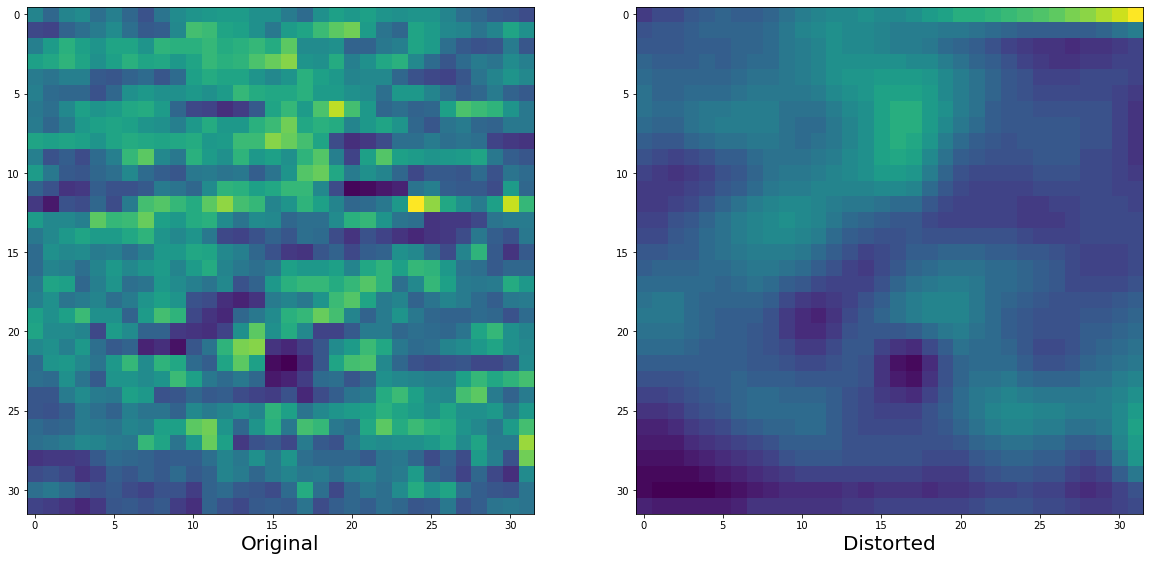

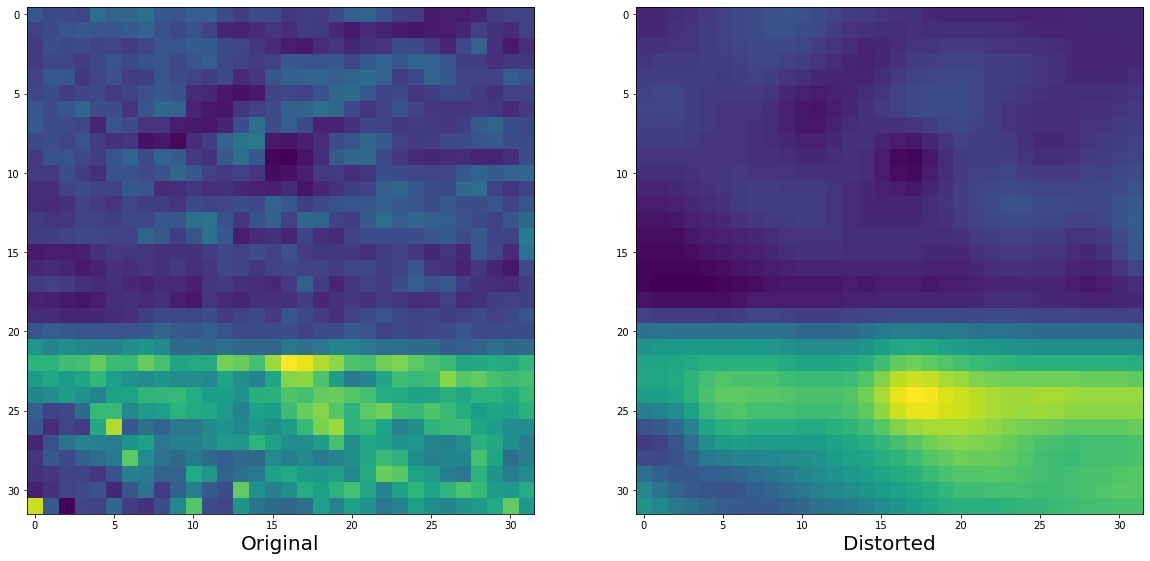

In [9]:
# sanity check to make sure image distortions are reasonable
for i in range(10000,10010):
    
    f, axarr = plt.subplots(1,2, figsize=(20, 20))
    axarr[0].imshow(training_images_gt_patches[i])
    axarr[0].set_xlabel('Original', fontsize=20)

    axarr[1].imshow(training_images_training_patches[i])
    axarr[1].set_xlabel('Distorted', fontsize=20)


In [10]:
# prep input training images for use in dataset
training_images_training_patches = np.array(training_images_training_patches)
print(training_images_training_patches.shape)

training_images_training_patches /= 255.0
training_images_training_patches -= train_pixel_mean
training_images_training_patches /= train_pixel_std

training_images_training_patches = torch.tensor(training_images_training_patches)
training_images_training_patches.shape


(105800, 32, 32)


torch.Size([105800, 32, 32])

In [11]:
my_training_dataset = data.TensorDataset(training_images_training_patches, training_images_gt_patches)
my_dataloader = data.DataLoader(my_training_dataset,
                                batch_size=128,
                                shuffle=True,
                                drop_last=True)

In [12]:
# generate validation set target images from BSDS500 val
val_img_names = [img for img in os.listdir('./data/train/BSDS500/data/images/val/') if img[-4:] == '.jpg']
val_images_gt_patches = []
for idx, img_name in enumerate(val_img_names):
    ImageFile = Image.open('./data/train/BSDS500/data/images/val/'+img_name)
    im_val = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_val_Y = im_val[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_val_Y.shape[0]/8) * 8
    max_y = int(im_val_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_val_Y = im_val_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_val_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_val_Y.shape[0]-32, 13):
            sub_im = im_val_Y[j:j+32, i:i+32]
            val_images_gt_patches.append(sub_im)


In [13]:
# prep target val images to be part of dataset

val_images_gt_patches = np.array(val_images_gt_patches)
print(val_images_gt_patches.shape)
#normalize
val_images_gt_patches /= 255.0
#standardize
val_images_gt_patches -= train_pixel_mean
val_images_gt_patches /= train_pixel_std

val_images_gt_patches = torch.tensor(val_images_gt_patches)
val_images_gt_patches.shape


(52900, 32, 32)


torch.Size([52900, 32, 32])

In [14]:
# prep distorted validation input images 
val_images_val_patches = []
for idx, img_name in enumerate(val_img_names):
    ImageFile = Image.open('./data/train/BSDS500/data/images/val/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='./data/train/BSDS500/data/images/val/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)

    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            val_images_val_patches.append(sub_im)


In [15]:
# prep input val images to be part of dataset

val_images_val_patches = np.array(val_images_val_patches)
print(val_images_val_patches.shape)
#normalize
val_images_val_patches /= 255.0
#standardize
val_images_val_patches -= train_pixel_mean
val_images_val_patches /= train_pixel_std

val_images_val_patches = torch.tensor(val_images_val_patches)
val_images_val_patches.shape


(52900, 32, 32)


torch.Size([52900, 32, 32])

In [ ]:
my_val_dataset = data.TensorDataset(val_images_val_patches, val_images_gt_patches)
my_val_dataloader = data.DataLoader(my_val_dataset,
                                    batch_size=128,
                                    shuffle=True,
                                    drop_last=True)


In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=7, padding=3)
        
        torch.nn.init.normal_(self.conv1.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv1.bias)
        
        torch.nn.init.normal_(self.conv2.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv2.bias)
        
        torch.nn.init.normal_(self.conv3.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv3.bias)

    def forward(self, img):
        out = F.relu(self.conv1(img))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out


In [ ]:
SR_model = SRCNN()
SR_model = SR_model.to(device)
print(SR_model.named_parameters)

criterion = torch.nn.MSELoss(reduction='mean').to(device)

optimizer = optim.SGD(
                      [
                          {"params": SR_model.conv1.parameters(), "lr": 0.0001},
                          {"params": SR_model.conv2.parameters(), "lr": 0.0001},
                          {"params": SR_model.conv3.parameters(), "lr": 0.00001},
                      ], momentum=0.9)

<bound method Module.named_parameters of SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)>


In [ ]:
best_val_loss = 10000.0
global_epoch = 0

In [ ]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
        
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

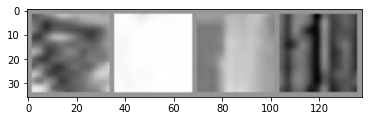

In [ ]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/SR_with_MSE_loss')
my_dataloader2 = data.DataLoader(my_training_dataset, batch_size=4, shuffle=True, drop_last=True)


        
# get some random training images
dataiter = iter(my_dataloader2)
images, labels = dataiter.next()


images_2 = torch.zeros((4,3,32,32))


images_2[:,0,:,:] = images
images_2[:,1,:,:] = images
images_2[:,2,:,:] = images


# create grid of images
img_grid = torchvision.utils.make_grid(images_2, nrow=4)
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_training_images', img_grid)

writer.add_graph(SR_model, images.unsqueeze(1).float().to(device))
writer.close()


In [ ]:
# train for 15x10^6 back-props

for epoch in range(9375-global_epoch):  # loop over the dataset multiple times
    print("epoch: ", global_epoch + 1)
    running_loss = 0.0
    for batch_i, data in enumerate(my_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, ground_truth = data
        inputs = inputs.float().to(device)
        ground_truth = ground_truth.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = SR_model(inputs.unsqueeze(1))
        
        loss = criterion(outputs.squeeze(), ground_truth.float())
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_i % 1000 == 999:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (global_epoch + 1, batch_i + 1, running_loss / 1000))
            # writer.add_scalar('training loss', running_loss / 1000,
                              # global_epoch * len(my_dataloader) + batch_i)
            running_loss = 0.0
    
    #end of epoch metric calculations         
    global_epoch += 1
    with torch.no_grad():

        val_loss = 0
        batch_i = 0
        for batch_i, data in enumerate(my_val_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, ground_truth = data
            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = SR_model(inputs.float().unsqueeze(1))
            val_loss += criterion(outputs.squeeze(), ground_truth.float())
        
        #get average loss per batch, to match how loss is reported in training
        val_loss = val_loss/(len(my_val_dataloader))
        # writer.add_scalar('validation loss', val_loss, global_epoch)
        
        print('epoch %d validation loss: %f'%(global_epoch, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
            print("New lowest loss found. Saving checkpoint.")
            torch.save({'epoch': global_epoch,
                        'model_state_dict': SR_model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val loss': val_loss
                        }, './checkpoint/checkpoint_SRCNN_w_MSE.pt')
        # eval over a unrelated dataset to track psnr
        
        mean_blur_psnr, mean_sr_psnr = evaluate_model(path='./data/evaluate/', 
                                                      model=SR_model, 
                                                      pixel_mean=train_pixel_mean, 
                                                      pixel_std=train_pixel_std)
        #note: evaluate_model was called when the default arg in the module
        # was 4 for SR_FACTOR. It is set to three now, and in the FDPL run
        # writer.add_scalars('Test5 PSNR (dB)', {'bicubic_psnr':mean_blur_psnr,
                                              #  'srcnn_psnr':mean_sr_psnr}, global_epoch)
        print("test5: bicubic = %f; srcnn = %f"%(mean_blur_psnr, mean_sr_psnr))
            
            
print('Finished Training')



epoch:  1
epoch 1 validation loss: 1.061217
New lowest loss found. Saving checkpoint.
test5: bicubic = 23.231272; srcnn = 11.127825
epoch:  2
epoch 2 validation loss: 1.061449
test5: bicubic = 23.231272; srcnn = 11.127825
epoch:  3
epoch 3 validation loss: 1.061522
test5: bicubic = 23.231272; srcnn = 11.127825
epoch:  4
epoch 4 validation loss: 1.061264
test5: bicubic = 23.231272; srcnn = 11.127825
epoch:  5
epoch 5 validation loss: 1.061293
test5: bicubic = 23.231272; srcnn = 11.127825
epoch:  6
epoch 6 validation loss: 1.061352
test5: bicubic = 23.231272; srcnn = 11.127825
epoch:  7
epoch 7 validation loss: 1.061155
New lowest loss found. Saving checkpoint.
test5: bicubic = 23.231272; srcnn = 11.127825
epoch:  8
epoch 8 validation loss: 1.061218
test5: bicubic = 23.231272; srcnn = 11.127825
epoch:  9
epoch 9 validation loss: 1.061034
New lowest loss found. Saving checkpoint.
test5: bicubic = 23.231272; srcnn = 11.127825
epoch:  10
epoch 10 validation loss: 1.059297
New lowest loss fo